## Machine Learning - Final Project (cars image classification)

#### Load needed libraries

In [1]:
#import libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import os
import PIL
import tarfile
import scipy.io
import cv2 as cv #OpenCV-Python is a library of Python bindings designed to solve computer vision problems.
import shutil
import random
from console_progressbar import ProgressBar

import seaborn as sns
import time


import torchvision
import torch
from PIL import Image
from torchvision import transforms
import matplotlib.animation as animation

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img

from glob import glob

###  Data Preprocessing
---
Current dataset consists of train and test dataset without identified classes, now we need to classify each image into 196 classes

In [2]:
def ensure_folder(folder):
    if not os.path.exists(folder):
        os.makedirs(folder)
        
def save_train_data(fnames, labels, bboxes):

    src_folder ='/Users/lianliu/Desktop/Uchicago/Machine Learning/input/standard-cars-dataset/cars_train/cars_train/'
    num_samples = len(fnames)

    train_split = 0.8
    num_train = int(round(num_samples * train_split))
    train_indexes = random.sample(range(num_samples), num_train)

    pb = ProgressBar(total=100, prefix='Save train data', suffix='', decimals=3, length=50, fill='=')

    for i in range(num_samples):
        fname = fnames[i]
        label = labels[i]
        (x1, y1, x2, y2) = bboxes[i]
        

        src_path = os.path.join(src_folder, fname)
        src_image = cv.imread(src_path) #cv.imread() method loads an image from the specified file.
        height, width = src_image.shape[:2]
        # margins of 16 pixels
        margin = 16
        x1 = max(0, x1 - margin)
        y1 = max(0, y1 - margin)
        x2 = min(x2 + margin, width)
        y2 = min(y2 + margin, height)
        # print("{} -> {}".format(fname, label))
        pb.print_progress_bar((i + 1) * 100 / num_samples)

        if i in train_indexes:
            dst_folder = '/Users/lianliu/Desktop/Uchicago/Machine Learning/project/train/'
        else:
            dst_folder = '/Users/lianliu/Desktop/Uchicago/Machine Learning/project/valid/'

        dst_path = os.path.join(dst_folder, label)
        if not os.path.exists(dst_path):
            os.makedirs(dst_path)
        dst_path = os.path.join(dst_path, fname)

        crop_image = src_image[y1:y2, x1:x2]
        dst_img = cv.resize(src=crop_image, dsize=(img_height, img_width))
        cv.imwrite(dst_path, dst_img)

In [3]:
def save_test_data(fnames, bboxes):
    src_folder = '/Users/lianliu/Desktop/Uchicago/Machine Learning/input/standard-cars-dataset/cars_test/cars_test'
    dst_folder = '/Users/lianliu/Desktop/Uchicago/Machine Learning/project/test/'
    num_samples = len(fnames)

    pb = ProgressBar(total=100, prefix='Save test data', suffix='', decimals=3, length=50, fill='=')

    for i in range(num_samples):
        fname = fnames[i]
        (x1, y1, x2, y2) = bboxes[i]
        src_path = os.path.join(src_folder, fname)
        src_image = cv.imread(src_path)
        height, width = src_image.shape[:2]
        # margins of 16 pixels
        margin = 16
        x1 = max(0, x1 - margin)
        y1 = max(0, y1 - margin)
        x2 = min(x2 + margin, width)
        y2 = min(y2 + margin, height)
        # print(fname)
        pb.print_progress_bar((i + 1) * 100 / num_samples)

        dst_path = os.path.join(dst_folder, fname)
        crop_image = src_image[y1:y2, x1:x2]
        dst_img = cv.resize(src=crop_image, dsize=(img_height, img_width))
        cv.imwrite(dst_path, dst_img)

In [4]:
def process_train_data():
    print("Processing train data...")
    
    #Load MATLAB file,which stores info for 196 classes
    cars_annos = scipy.io.loadmat('/Users/lianliu/Desktop/Uchicago/Machine Learning/input/cars_devkit/cars_train_annos.mat')
    #Annotations are graphical elements, often pieces of text, explain some portion of the visualized data.
    annotations = cars_annos['annotations']
    annotations = np.transpose(annotations)

    fnames = []
    class_ids = []
    bboxes = []
    labels = []

    for annotation in annotations:
        bbox_x1 = annotation[0][0][0][0]
        bbox_y1 = annotation[0][1][0][0]
        bbox_x2 = annotation[0][2][0][0]
        bbox_y2 = annotation[0][3][0][0]
        class_id = annotation[0][4][0][0]
        labels.append('%04d' % (class_id,))
        fname = annotation[0][5][0]
        bboxes.append((bbox_x1, bbox_y1, bbox_x2, bbox_y2))
        class_ids.append(class_id)
        fnames.append(fname)

    labels_count = np.unique(class_ids).shape[0]
    print(np.unique(class_ids))
    print('The number of different cars is %d' % labels_count)

    save_train_data(fnames, labels, bboxes)

In [5]:
def process_test_data():
    print("Processing test data...")
    cars_annos = scipy.io.loadmat('/Users/lianliu/Desktop/Uchicago/Machine Learning/input/cars_devkit/cars_test_annos.mat')
    annotations = cars_annos['annotations']
    annotations = np.transpose(annotations)

    fnames = []
    bboxes = []

    for annotation in annotations:
        bbox_x1 = annotation[0][0][0][0]
        bbox_y1 = annotation[0][1][0][0]
        bbox_x2 = annotation[0][2][0][0]
        bbox_y2 = annotation[0][3][0][0]
        fname = annotation[0][4][0]
        bboxes.append((bbox_x1, bbox_y1, bbox_x2, bbox_y2))
        fnames.append(fname)

    save_test_data(fnames, bboxes)

#### Split dataset and save

In [6]:
img_width, img_height = 224, 224

cars_meta = scipy.io.loadmat('/Users/lianliu/Desktop/Uchicago/Machine Learning/input/cars_devkit/cars_meta.mat')
class_names = cars_meta['class_names']  # shape=(1, 196)
class_names = np.transpose(class_names)
print('class_names.shape: ' + str(class_names.shape))
print('Sample class_name: [{}]'.format(class_names[8][0][0]))

ensure_folder('/Users/lianliu/Desktop/Uchicago/Machine Learning/project/train/')
ensure_folder('/Users/lianliu/Desktop/Uchicago/Machine Learning/project/valid/')
ensure_folder('/Users/lianliu/Desktop/Uchicago/Machine Learning/project/test')

process_train_data()
process_test_data()

class_names.shape: (196, 1)
Sample class_name: [Aston Martin V8 Vantage Coupe 2012]
Processing train data...
[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196]
The number of different cars is 196
Save train data |==========================================

## Exploratory Data Analysis & Feature Engineering

#### 1.visulize the images with different classes 

In [7]:
# tot_images_viz = no. of images that you want to visualize from each class
# num_class = no. of classes that you want to visualize

tot_images_viz, num_classes, img_size = 10, 16, 224

train_im_dir = '/Users/lianliu/Desktop/Uchicago/Machine Learning/project/train/'
img_paths = [train_im_dir + str(i).zfill(4) + '/' + fn for i in range(1,5) \
                 for fn in os.listdir(train_im_dir + str(i).zfill(4))[:tot_images_viz] ]    
#The zfill() method adds zeros (0) at the beginning of the string, until it reaches the specified length.


img_dict = {}
for i in range(1,num_classes+1):
    img_dict[i] = list(map(lambda x: train_im_dir + str(i).zfill(4) + '/' + x,
                      os.listdir(train_im_dir + str(i).zfill(4))[:tot_images_viz]))

        

In [8]:
def im2tensor(file_names,bs=num_classes):
    all_im = torch.zeros((bs,3,img_size,img_size)) #Returns a tensor filled with the scalar value 0
    custom_transform = transforms.Compose([transforms.Resize((img_size, img_size)),                                           
                                           transforms.ToTensor()])
    for i,fn in enumerate(file_names):
        all_im[i,:,:,:] = (custom_transform(Image.open(fn)))
        
    return all_im

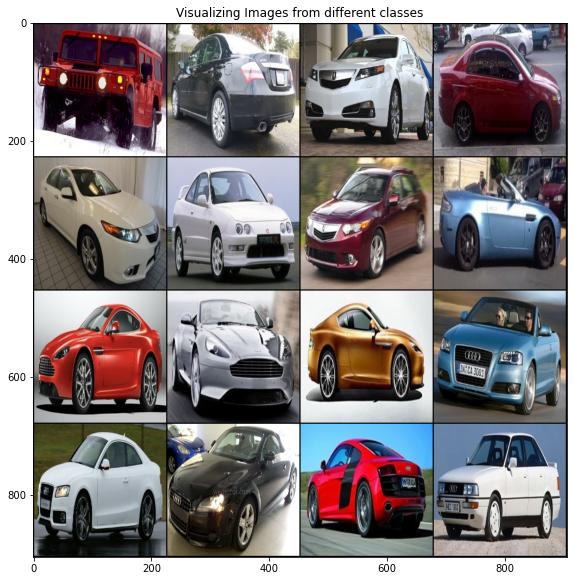

In [9]:
fig = plt.figure(figsize=(8,8))
imgs = []
class_name_list = scipy.io.loadmat('/Users/lianliu/Desktop/Uchicago/Machine Learning/input/standard-cars-dataset/cars_annos.mat')['class_names'].flatten()
class_name_list = list(map(lambda x: x[0],class_name_list))

for i in range(0,tot_images_viz):
    fn = [img_dict[j][i] for j in range(1,num_classes+1)]
    all_im = im2tensor(fn)
    
    grid = torchvision.utils.make_grid(all_im,4)
    ndarr = grid.mul(255).clamp(0, 255).byte().permute(1, 2, 0).cpu().numpy()
    im = Image.fromarray(ndarr)
    im = plt.imshow(im, animated=True) 
    imgs.append([im])

ani = animation.ArtistAnimation(fig, imgs, interval=1000, blit=True,
                                repeat_delay=1000)
plt.tight_layout()
plt.title('Visualizing Images from different classes')

ani.save('car_images.gif')

#### 2. check basic information about the train dataset and plot car counts in each class

In [10]:
all_img_dict = {}
num_class_visualize,class_count = 196,[]
for i in range(1,num_class_visualize+1):
    class_count.append(len(os.listdir(train_im_dir + str(i).zfill(4))))

class_count = np.array(class_count)
class_count_df = pd.DataFrame(class_count,columns=['class_count'])
print(class_count_df.describe())
print('Class with min count',class_count.argmin())
print('Class with max count',class_count.argmax())

       class_count
count   196.000000
mean     33.239796
std       4.319146
min      20.000000
25%      31.000000
50%      33.000000
75%      36.000000
max      55.000000
Class with min count 135
Class with max count 118


25 out 196 classes have 34 images


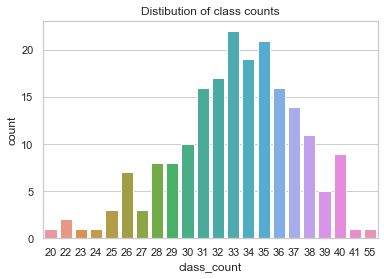

In [11]:
import seaborn as sns
sns.set_theme(style="whitegrid")

sns.countplot(x= class_count_df.class_count)
plt.title('Distibution of class counts')
print('25 out 196 classes have 34 images')

#### 3. PCA

In [12]:
all_img_dict = {}
num_class_visualize = 10
for i in range(1,num_class_visualize+1):
    all_img_dict[i] = list(map(lambda x: train_im_dir + str(i).zfill(4) + '/' + x,
                      os.listdir(train_im_dir + str(i).zfill(4))))

In [13]:
images = []
labels = []
resized_img_size = 100

for class_name,file_names in all_img_dict.items():
        for fn in file_names:
            image = np.array(Image.open(fn)).flatten()
            image = cv.resize(image,(resized_img_size,
                                      resized_img_size))
    
            images.append(image.flatten())
            labels.append(class_name)

        
images = np.array(images)
print(images.shape)
labels = np.array(labels)

(316, 10000)


In [14]:
feat_cols = [ 'pixel'+str(i) for i in range(resized_img_size**2) ]

df = pd.DataFrame(images,columns=feat_cols)
df['y'] = labels
df['label'] = df['y'].apply(lambda i: class_name_list[i])

X, y = None, None

print('Size of the dataframe: {}'.format(df.shape))

# For reproducability of the results
np.random.seed(42)

rndperm = np.random.permutation(df.shape[0])

Size of the dataframe: (316, 10002)


In [15]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(df[feat_cols].values)

df['pca-one'] = pca_result[:,0]
df['pca-two'] = pca_result[:,1] 
df['pca-three'] = pca_result[:,2]

print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.17823004 0.10328821 0.06610382]


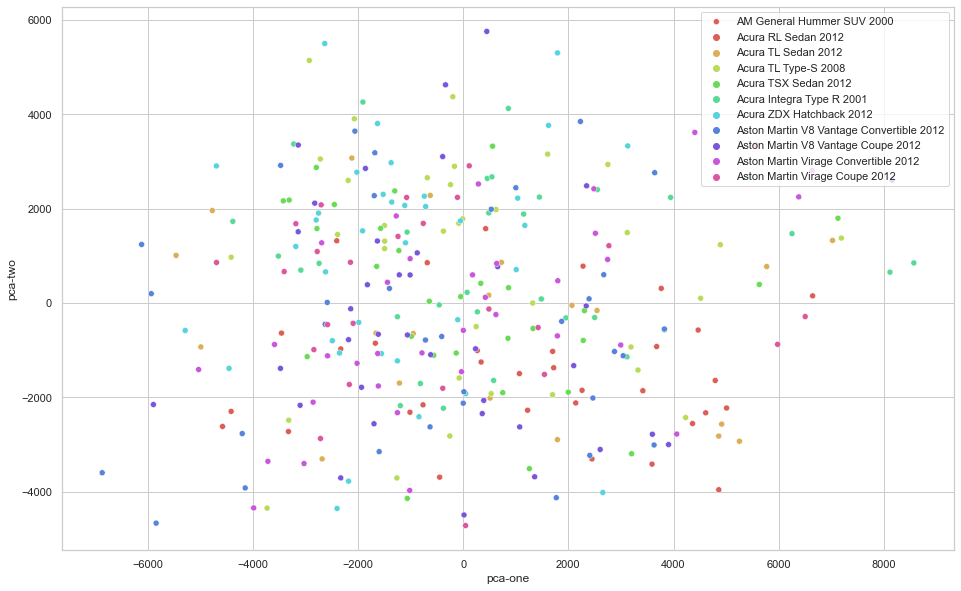

In [16]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="y",
    palette=sns.color_palette("hls", num_class_visualize),
    data=df,
#     legend="full",
    alpha=1
)
plt.legend(class_name_list)

#### 4. load the dataset and feature engineering

In [87]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


train_datagen = ImageDataGenerator(
        rescale=1./255
)


# ImageDataGenerator flow_from_directory for train dataset
train_generator = train_datagen.flow_from_directory(
        directory='/Users/lianliu/Desktop/Uchicago/Machine Learning/project/train/',
        target_size=(224,224),
        batch_size=32,
        class_mode='categorical'
)

# ImageDataGenerator flow_from_directory for valid dataset
valid_generator = train_datagen.flow_from_directory(
        directory= '/Users/lianliu/Desktop/Uchicago/Machine Learning/project/valid/',
        target_size=(224,224),
        batch_size=32,
        class_mode='categorical'
)

Found 6515 images belonging to 196 classes.
Found 1629 images belonging to 196 classes.


## Proposed Approaches (Model) with checks for overfitting/underfitting


In [88]:
import os
import sys
import numpy as np
from skimage.io import imread
import matplotlib.pyplot as plt
import numpy as np
import keras
import pandas as pd
from PIL import Image
import cv2


from tensorflow.keras.applications.resnet50 import ResNet50
from keras.preprocessing.image import ImageDataGenerator

from keras.applications.imagenet_utils import decode_predictions

from efficientnet.keras import EfficientNetB0,EfficientNetB3
from efficientnet.keras import center_crop_and_resize, preprocess_input
from keras.optimizers import SGD, Adam
from keras.layers.pooling import MaxPooling2D,AveragePooling2D


#### 1. build models #1

In [89]:
IMAGE_SIZE = [224, 224] 

resnet = ResNet50(
    input_shape = IMAGE_SIZE + [3], # Making the image into 3 Channel, so concating 3.
    weights = 'imagenet', # Default weights.
    include_top = False   # 
)

#resnet.summary()

In [90]:
from tensorflow.keras.models import Model

for layer in resnet.layers:
    layer.trainable = False # This will let us use the default weights used by the imagenet.    
    
# Set the flatten layer.
x = Flatten() (resnet.output)

prediction = Dense(len(class_name_list), activation = 'softmax')(x)

# Create a model Object
model2 = Model(inputs = resnet.input, outputs = prediction)

In [91]:
#compile the model
model2.compile (
    loss = 'categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

#fit the model
history_model2 = model2.fit_generator(
    train_generator,
    validation_data = valid_generator,
    epochs = 50,
    steps_per_epoch = 6515//50,
    validation_steps = 1629//50
)

/var/folders/b6/80w17k151_ndnz0x5hpf7scr0000gn/T/ipykernel_1690/2176363213.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_model2 = model2.fit_generator(


Epoch 1/50
130/130 [==============================] - 126s 955ms/step - loss: 31.2714 - accuracy: 0.0060 - val_loss: 20.0037 - val_accuracy: 0.0088
Epoch 2/50
130/130 [==============================] - 124s 954ms/step - loss: 14.7565 - accuracy: 0.0106 - val_loss: 16.6187 - val_accuracy: 0.0146
Epoch 3/50
130/130 [==============================] - 123s 946ms/step - loss: 15.2316 - accuracy: 0.0139 - val_loss: 18.4276 - val_accuracy: 0.0098
Epoch 4/50
130/130 [==============================] - 123s 947ms/step - loss: 16.2249 - accuracy: 0.0157 - val_loss: 14.7983 - val_accuracy: 0.0127
Epoch 5/50
130/130 [==============================] - 124s 954ms/step - loss: 15.5419 - accuracy: 0.0192 - val_loss: 17.3425 - val_accuracy: 0.0146
Epoch 6/50
130/130 [==============================] - 123s 949ms/step - loss: 14.2921 - accuracy: 0.0224 - val_loss: 15.3810 - val_accuracy: 0.0137
Epoch 7/50
130/130 [==============================] - 124s 953ms/step - loss: 14.8242 - accuracy: 0.0221 - val_l

In [94]:
model2.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_7[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

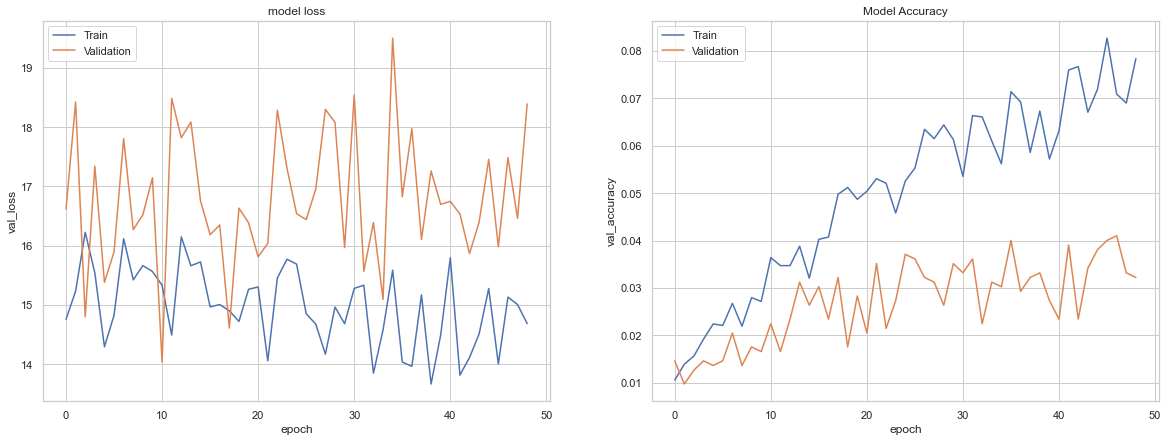

In [95]:
def plot_loss_acc(history):
    plt.figure(figsize=(20,7))
    plt.subplot(1,2,1)
    plt.plot(history_model2.history['loss'][1:])    
    plt.plot(history_model2.history['val_loss'][1:])    
    plt.title('model loss')    
    plt.ylabel('val_loss')    
    plt.xlabel('epoch')    
    plt.legend(['Train','Validation'], loc='upper left')
    
    plt.subplot(1,2,2)
    plt.plot(history_model2.history['accuracy'][1:])
    plt.plot(history_model2.history['val_accuracy'][1:])
    plt.title('Model Accuracy')
    plt.ylabel('val_accuracy')
    plt.xlabel('epoch')
    plt.legend(['Train','Validation'], loc='upper left')
    plt.show()

plot_loss_acc(history_model2)

In [96]:
from tqdm import tqdm_notebook
import scipy.io as sio

num_samples,all_preds = 8041,[]
out = open('result.txt', 'a')
for i in tqdm_notebook(range(num_samples)):
    filename = os.path.join('/Users/lianliu/Desktop/Uchicago/Machine Learning/project/test', '%05d.jpg' % (i + 1))
    bgr_img = cv.imread(filename)
    rgb_img = cv.resize(cv.cvtColor(bgr_img, cv.COLOR_BGR2RGB)/255,(224,224))
    rgb_img = np.expand_dims(rgb_img, 0)
    preds = model2.predict(rgb_img)
    class_id = np.argmax(preds)
    all_preds.append(class_id)
    out.write('{}\n'.format(str(class_id + 1)))
    
out.close()

/var/folders/b6/80w17k151_ndnz0x5hpf7scr0000gn/T/ipykernel_1690/462534682.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(num_samples)):


  0%|          | 0/8041 [00:00<?, ?it/s]

1/1 [==============================] - 0s 59ms/step


1/1 [==============================] - 0s 56ms/step


1/1 [==============================] - 0s 56ms/step


1/1 [==============================] - 0s 55ms/step


1/1 [==============================] - 0s 53ms/step


1/1 [==============================] - 0s 55ms/step


1/1 [==============================] - 0s 54ms/step


1/1 [==============================] - 0s 55ms/step


1/1 [==============================] - 0s 56ms/step


1/1 [==============================] - 0s 58ms/step


1/1 [==============================] - 0s 59ms/step


1/1 [==============================] - 0s 56ms/step


1/1 [==============================] - 0s 54ms/step


1/1 [==============================] - 0s 55ms/step


1/1 [==============================] - 0s 57ms/step


1/1 [==============================] - 0s 60ms/step


1/1 [==============================] - 0s 55ms/step


1/1 [==============================] - 0s 55ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 55ms/step


1/1 [==============================] - 0s 55ms/step


1/1 [==============================] - 0s 53ms/step


1/1 [==============================] - 0s 52ms/step


1/1 [==============================] - 0s 57ms/step


1/1 [==============================] - 0s 57ms/step


1/1 [==============================] - 0s 55ms/step


1/1 [==============================] - 0s 54ms/step


1/1 [==============================] - 0s 56ms/step


1/1 [==============================] - 0s 54ms/step


1/1 [==============================] - 0s 58ms/step


1/1 [==============================] - 0s 55ms/step


1/1 [==============================] - 0s 55ms/step


1/1 [==============================] - 0s 55ms/step


1/1 [==============================] - 0s 54ms/step


1/1 [==============================] - 0s 54ms/step


1/1 [==============================] - 0s 56ms/step


1/1 [==============================] - 0s 57ms/step


1/1 [==============================] - 0s 55ms/step


1/1 [==============================] - 0s 63ms/step


1/1 [==============================] - 0s 55ms/step


1/1 [==============================] - 0s 66ms/step


1/1 [==============================] - 0s 74ms/step


1/1 [==============================] - 0s 54ms/step


1/1 [==============================] - 0s 53ms/step


1/1 [==============================] - 0s 54ms/step


1/1 [==============================] - 0s 53ms/step


1/1 [==============================] - 0s 60ms/step


1/1 [==============================] - 0s 55ms/step


1/1 [==============================] - 0s 54ms/step


1/1 [==============================] - 0s 53ms/step


1/1 [==============================] - 0s 57ms/step


1/1 [==============================] - 0s 55ms/step


In [97]:
labels = sio.loadmat('/Users/lianliu/Desktop/Uchicago/Machine Learning/input/cars_devkit/cars_test_annos_withlabels.mat')
actual_preds = np.array(labels['annotations']['class'],dtype=int)-1;
actual_preds = actual_preds.squeeze()
all_preds = np.array(all_preds)

print('accuracy = ',(all_preds==actual_preds).sum()/len(actual_preds))

accuracy =  0.04825270488745181


#### 2.build model #2

In [66]:
class SnapshotCallbackBuilder:
    def __init__(self, nb_epochs, nb_snapshots, init_lr=0.1):
        self.T = nb_epochs
        self.M = nb_snapshots
        self.alpha_zero = init_lr

    def get_callbacks(self, model_prefix='Model'):

        callback_list = [
#             callbacks.ModelCheckpoint("./keras.model",monitor='val_loss', 
#                                    mode = 'min', save_best_only=True, verbose=1),
            swa,
            callbacks.LearningRateScheduler(schedule=self._cosine_anneal_schedule)
        ]

        return callback_list

    def _cosine_anneal_schedule(self, t):
        cos_inner = np.pi * (t % (self.T // self.M))  # t - 1 is used when t has 1-based indexing.
        cos_inner /= self.T // self.M
        cos_out = np.cos(cos_inner) + 1
        return float(self.alpha_zero / 2 * cos_out)

import keras.callbacks as callbacks

class SWA(keras.callbacks.Callback):
    
    def __init__(self, filepath, swa_epoch):
        super(SWA, self).__init__()
        self.filepath = filepath
        self.swa_epoch = swa_epoch 
    
    def on_train_begin(self, logs=None):
        self.nb_epoch = self.params['epochs']
        print('Stochastic weight averaging selected for last {} epochs.'
              .format(self.nb_epoch - self.swa_epoch))
        
    def on_epoch_end(self, epoch, logs=None):
        
        if epoch == self.swa_epoch:
            self.swa_weights = self.model.get_weights()
            
        elif epoch > self.swa_epoch:    
            for i in range(len(self.swa_weights)):
                self.swa_weights[i] = (self.swa_weights[i] * 
                    (epoch - self.swa_epoch) + self.model.get_weights()[i])/((epoch - self.swa_epoch)  + 1)  

        else:
            pass
        
    def on_train_end(self, logs=None):
        self.model.set_weights(self.swa_weights)
        print('Final model parameters set to stochastic weight average.')
        self.model.save_weights(self.filepath)
        print('Final stochastic averaged weights saved to file.')

In [77]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        rotation_range=20.,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=[0.9, 1.25],
        brightness_range=[0.5, 1.5],
        horizontal_flip=True)

#test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        directory='/Users/lianliu/Desktop/Uchicago/Machine Learning/project/train/',
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
        directory= '/Users/lianliu/Desktop/Uchicago/Machine Learning/project/valid/',
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical')


Found 6515 images belonging to 196 classes.
Found 1629 images belonging to 196 classes.


In [78]:
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.models import Sequential, Model

def build_finetune_model(base_model, dropout, num_classes):

    x = base_model.output
    
    x = AveragePooling2D((5, 5), name='avg_pool')(x)
    x = Flatten()(x)
    x = Dropout(dropout)(x)
    predictions = Dense(num_classes, activation='softmax', name='finalfc')(x)
    
    finetune_model = Model(inputs=base_model.input, outputs=predictions)

    return finetune_model

In [82]:
HEIGHT = 224
WIDTH = 224

input_shape=(HEIGHT, WIDTH, 3)

dropout = 0.5
epochs = 100
swa = SWA('./keras_swa.model',epochs-3)

base_model = EfficientNetB3(weights='imagenet',
                            include_top=False,
                            input_shape=(HEIGHT, WIDTH, 3))

finetune_model = build_finetune_model(base_model, 
                                      dropout=dropout, 
                                      num_classes=196)

finetune_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

snapshot = SnapshotCallbackBuilder(nb_epochs=epochs,nb_snapshots=1,init_lr=1e-3)

history = finetune_model.fit_generator(generator=train_generator,
                                        validation_data=validation_generator,
                                        steps_per_epoch=6515//epochs,
                                        epochs=epochs,
                                        verbose=2,
                                        validation_steps=1629//epochs,
                                        callbacks=snapshot.get_callbacks())

try:
    finetune_model.load_weights('./keras_swa.model')
except Exception as e:
    print(e)

/var/folders/b6/80w17k151_ndnz0x5hpf7scr0000gn/T/ipykernel_1690/2251722692.py:22: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = finetune_model.fit_generator(generator=train_generator,


Stochastic weight averaging selected for last 3 epochs.
Epoch 1/100
65/65 - 186s - loss: 5.2519 - accuracy: 0.0188 - val_loss: 5.1255 - val_accuracy: 0.0332 - lr: 0.0010 - 186s/epoch - 3s/step
Epoch 2/100
65/65 - 169s - loss: 4.5365 - accuracy: 0.0856 - val_loss: 6.0198 - val_accuracy: 0.0742 - lr: 9.9975e-04 - 169s/epoch - 3s/step
Epoch 3/100
65/65 - 168s - loss: 3.6650 - accuracy: 0.1882 - val_loss: 3.2452 - val_accuracy: 0.2188 - lr: 9.9901e-04 - 168s/epoch - 3s/step
Epoch 4/100
65/65 - 169s - loss: 2.7833 - accuracy: 0.3125 - val_loss: 2.8740 - val_accuracy: 0.2988 - lr: 9.9778e-04 - 169s/epoch - 3s/step
Epoch 5/100
65/65 - 169s - loss: 2.1953 - accuracy: 0.4279 - val_loss: 2.2548 - val_accuracy: 0.4219 - lr: 9.9606e-04 - 169s/epoch - 3s/step
Epoch 6/100
65/65 - 168s - loss: 1.8009 - accuracy: 0.5288 - val_loss: 1.8469 - val_accuracy: 0.5000 - lr: 9.9384e-04 - 168s/epoch - 3s/step
Epoch 7/100
65/65 - 168s - loss: 1.4541 - accuracy: 0.6086 - val_loss: 1.8034 - val_accuracy: 0.5273 -

Epoch 59/100
65/65 - 169s - loss: 0.0405 - accuracy: 0.9885 - val_loss: 0.5635 - val_accuracy: 0.8848 - lr: 3.7566e-04 - 169s/epoch - 3s/step
Epoch 60/100
65/65 - 168s - loss: 0.0350 - accuracy: 0.9894 - val_loss: 0.5394 - val_accuracy: 0.8906 - lr: 3.6050e-04 - 168s/epoch - 3s/step
Epoch 61/100
65/65 - 169s - loss: 0.0445 - accuracy: 0.9846 - val_loss: 0.4193 - val_accuracy: 0.8867 - lr: 3.4549e-04 - 169s/epoch - 3s/step
Epoch 62/100
65/65 - 169s - loss: 0.0402 - accuracy: 0.9865 - val_loss: 0.5856 - val_accuracy: 0.8711 - lr: 3.3063e-04 - 169s/epoch - 3s/step
Epoch 63/100
65/65 - 169s - loss: 0.0319 - accuracy: 0.9904 - val_loss: 0.5105 - val_accuracy: 0.8867 - lr: 3.1594e-04 - 169s/epoch - 3s/step
Epoch 64/100
65/65 - 169s - loss: 0.0325 - accuracy: 0.9923 - val_loss: 0.5373 - val_accuracy: 0.8828 - lr: 3.0143e-04 - 169s/epoch - 3s/step
Epoch 65/100
65/65 - 168s - loss: 0.0349 - accuracy: 0.9894 - val_loss: 0.4716 - val_accuracy: 0.8887 - lr: 2.8711e-04 - 168s/epoch - 3s/step
Epoch 

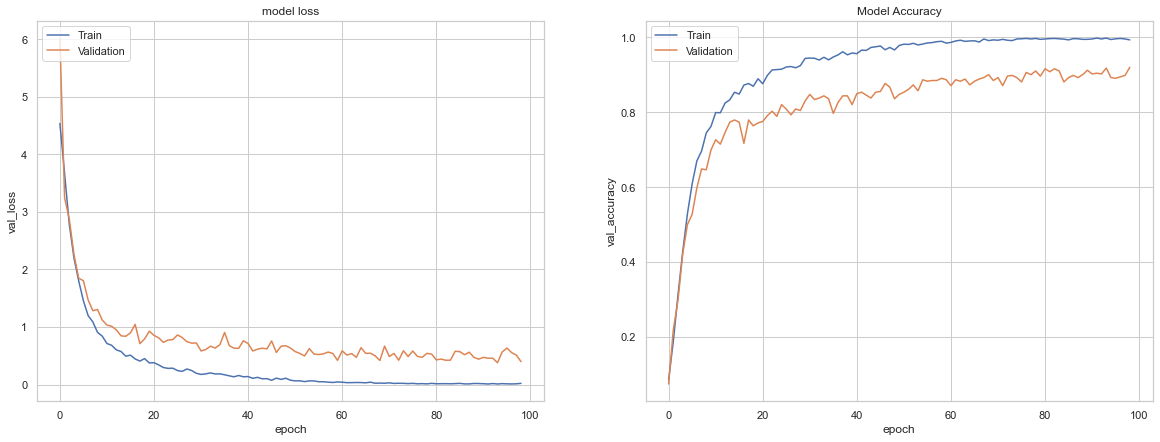

In [83]:
def plot_loss_acc(history):
    plt.figure(figsize=(20,7))
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'][1:])    
    plt.plot(history.history['val_loss'][1:])    
    plt.title('model loss')    
    plt.ylabel('val_loss')    
    plt.xlabel('epoch')    
    plt.legend(['Train','Validation'], loc='upper left')
    
    plt.subplot(1,2,2)
    plt.plot(history.history['accuracy'][1:])
    plt.plot(history.history['val_accuracy'][1:])
    plt.title('Model Accuracy')
    plt.ylabel('val_accuracy')
    plt.xlabel('epoch')
    plt.legend(['Train','Validation'], loc='upper left')
    plt.show()

plot_loss_acc(history)

#### According to the learning curve plot above, there are no obvious sign of overfitting and underfitting but a good fit learning curves. First of all, both trainning and validation losss decreases with expeirence to a point of stability and doesn't seen to begin increase again. In addition, the gap ("generation gap") between two datasets are not large.

In [84]:
finetune_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv (Conv2D)             (None, 112, 112, 40  1080        ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 stem_bn (BatchNormalization)   (None, 112, 112, 40  160         ['stem_conv[0][0]']              
                                )                                                           

                                                                                                  
 block2a_dwconv (DepthwiseConv2  (None, 56, 56, 144)  1296       ['block2a_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block2a_bn (BatchNormalization  (None, 56, 56, 144)  576        ['block2a_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block2a_activation (Activation  (None, 56, 56, 144)  0          ['block2a_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block2a_s

 block2c_se_squeeze (GlobalAver  (None, 192)         0           ['block2c_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block2c_se_reshape (Reshape)   (None, 1, 1, 192)    0           ['block2c_se_squeeze[0][0]']     
                                                                                                  
 block2c_se_reduce (Conv2D)     (None, 1, 1, 8)      1544        ['block2c_se_reshape[0][0]']     
                                                                                                  
 block2c_se_expand (Conv2D)     (None, 1, 1, 192)    1728        ['block2c_se_reduce[0][0]']      
                                                                                                  
 block2c_se_excite (Multiply)   (None, 56, 56, 192)  0           ['block2c_activation[0][0]',     
          

                                                                  'block3b_se_expand[0][0]']      
                                                                                                  
 block3b_project_conv (Conv2D)  (None, 28, 28, 48)   13824       ['block3b_se_excite[0][0]']      
                                                                                                  
 block3b_project_bn (BatchNorma  (None, 28, 28, 48)  192         ['block3b_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block3b_drop (FixedDropout)    (None, 28, 28, 48)   0           ['block3b_project_bn[0][0]']     
                                                                                                  
 block3b_add (Add)              (None, 28, 28, 48)   0           ['block3b_drop[0][0]',           
          

 lization)                                                                                        
                                                                                                  
 block4b_expand_conv (Conv2D)   (None, 14, 14, 576)  55296       ['block4a_project_bn[0][0]']     
                                                                                                  
 block4b_expand_bn (BatchNormal  (None, 14, 14, 576)  2304       ['block4b_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block4b_expand_activation (Act  (None, 14, 14, 576)  0          ['block4b_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block4b_d

 ization)                                                                                         
                                                                                                  
 block4d_expand_activation (Act  (None, 14, 14, 576)  0          ['block4d_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block4d_dwconv (DepthwiseConv2  (None, 14, 14, 576)  5184       ['block4d_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block4d_bn (BatchNormalization  (None, 14, 14, 576)  2304       ['block4d_dwconv[0][0]']         
 )                                                                                                
          

 block5a_dwconv (DepthwiseConv2  (None, 14, 14, 576)  14400      ['block5a_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block5a_bn (BatchNormalization  (None, 14, 14, 576)  2304       ['block5a_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block5a_activation (Activation  (None, 14, 14, 576)  0          ['block5a_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block5a_se_squeeze (GlobalAver  (None, 576)         0           ['block5a_activation[0][0]']     
 agePoolin

 agePooling2D)                                                                                    
                                                                                                  
 block5c_se_reshape (Reshape)   (None, 1, 1, 816)    0           ['block5c_se_squeeze[0][0]']     
                                                                                                  
 block5c_se_reduce (Conv2D)     (None, 1, 1, 34)     27778       ['block5c_se_reshape[0][0]']     
                                                                                                  
 block5c_se_expand (Conv2D)     (None, 1, 1, 816)    28560       ['block5c_se_reduce[0][0]']      
                                                                                                  
 block5c_se_excite (Multiply)   (None, 14, 14, 816)  0           ['block5c_activation[0][0]',     
                                                                  'block5c_se_expand[0][0]']      
          

                                                                                                  
 block5e_se_expand (Conv2D)     (None, 1, 1, 816)    28560       ['block5e_se_reduce[0][0]']      
                                                                                                  
 block5e_se_excite (Multiply)   (None, 14, 14, 816)  0           ['block5e_activation[0][0]',     
                                                                  'block5e_se_expand[0][0]']      
                                                                                                  
 block5e_project_conv (Conv2D)  (None, 14, 14, 136)  110976      ['block5e_se_excite[0][0]']      
                                                                                                  
 block5e_project_bn (BatchNorma  (None, 14, 14, 136)  544        ['block5e_project_conv[0][0]']   
 lization)                                                                                        
          

                                                                                                  
 block6b_drop (FixedDropout)    (None, 7, 7, 232)    0           ['block6b_project_bn[0][0]']     
                                                                                                  
 block6b_add (Add)              (None, 7, 7, 232)    0           ['block6b_drop[0][0]',           
                                                                  'block6a_project_bn[0][0]']     
                                                                                                  
 block6c_expand_conv (Conv2D)   (None, 7, 7, 1392)   322944      ['block6b_add[0][0]']            
                                                                                                  
 block6c_expand_bn (BatchNormal  (None, 7, 7, 1392)  5568        ['block6c_expand_conv[0][0]']    
 ization)                                                                                         
          

                                                                                                  
 block6e_expand_conv (Conv2D)   (None, 7, 7, 1392)   322944      ['block6d_add[0][0]']            
                                                                                                  
 block6e_expand_bn (BatchNormal  (None, 7, 7, 1392)  5568        ['block6e_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block6e_expand_activation (Act  (None, 7, 7, 1392)  0           ['block6e_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block6e_dwconv (DepthwiseConv2  (None, 7, 7, 1392)  34800       ['block6e_expand_activation[0][0]
 D)       

                                                                                                  
 block7a_expand_activation (Act  (None, 7, 7, 1392)  0           ['block7a_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block7a_dwconv (DepthwiseConv2  (None, 7, 7, 1392)  12528       ['block7a_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block7a_bn (BatchNormalization  (None, 7, 7, 1392)  5568        ['block7a_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block7a_a

Total params: 11,084,780
Trainable params: 10,997,484
Non-trainable params: 87,296
__________________________________________________________________________________________________


In [85]:
from tqdm import tqdm_notebook
import scipy.io as sio

num_samples,all_preds = 8041,[]
out = open('result.txt', 'a')
for i in tqdm_notebook(range(num_samples)):
    filename = os.path.join('/Users/lianliu/Desktop/Uchicago/Machine Learning/project/test', '%05d.jpg' % (i + 1))
    bgr_img = cv.imread(filename)
    rgb_img = cv.resize(cv.cvtColor(bgr_img, cv.COLOR_BGR2RGB)/255,(224,224))
    rgb_img = np.expand_dims(rgb_img, 0)
    preds = finetune_model.predict(rgb_img)
    class_id = np.argmax(preds)
    all_preds.append(class_id)
    out.write('{}\n'.format(str(class_id + 1)))
    
out.close()

/var/folders/b6/80w17k151_ndnz0x5hpf7scr0000gn/T/ipykernel_1690/3868526612.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(num_samples)):


  0%|          | 0/8041 [00:00<?, ?it/s]

1/1 [==============================] - 0s 46ms/step


1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - 0s 48ms/step


1/1 [==============================] - 0s 51ms/step


1/1 [==============================] - 0s 49ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 46ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 46ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 46ms/step


1/1 [==============================] - 0s 46ms/step


1/1 [==============================] - 0s 46ms/step


1/1 [==============================] - 0s 45ms/step


1/1 [==============================] - 0s 46ms/step


1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - 0s 54ms/step


1/1 [==============================] - 0s 46ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 48ms/step


1/1 [==============================] - 0s 46ms/step


1/1 [==============================] - 0s 46ms/step


1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 46ms/step


1/1 [==============================] - 0s 45ms/step


1/1 [==============================] - 0s 46ms/step


1/1 [==============================] - 0s 46ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 45ms/step


1/1 [==============================] - 0s 45ms/step


1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - 0s 46ms/step


1/1 [==============================] - 0s 46ms/step


1/1 [==============================] - 0s 53ms/step


1/1 [==============================] - 0s 48ms/step


1/1 [==============================] - 0s 52ms/step


1/1 [==============================] - 0s 46ms/step


1/1 [==============================] - 0s 48ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 45ms/step


1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - 0s 43ms/step


In [86]:
labels = sio.loadmat('/Users/lianliu/Desktop/Uchicago/Machine Learning/input/cars_devkit/cars_test_annos_withlabels.mat')
actual_preds = np.array(labels['annotations']['class'],dtype=int)-1;
actual_preds = actual_preds.squeeze()
all_preds = np.array(all_preds)

print('accuracy = ',(all_preds==actual_preds).sum()/len(actual_preds))


accuracy =  0.9121999751274718
